## Time Series in RNN

In this tutorial, we will use an RNN with time-series data. Time series is dependent on the previous time, which means past values include significant information that the network can learn. The time series prediction is to estimate the future value of any series, let's say, stock price, temperature, GDP, and many more.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, SimpleRNN

### Generating sample dataset

In [86]:
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)
df.head()

,0
0,0.536051
1,1.768857
2,0.153105
3,0.666013
4,1.623605


Text(0.5, 1.0, 'A time series (generated)')

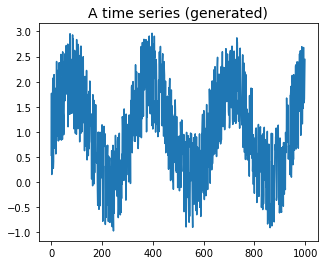

In [87]:
# Left plotting diagram  
plt.figure(figsize=(11,4))  
plt.subplot(121)  
plt.plot(df)  
plt.title("A time series (generated)", fontsize=14)  

## Step 1) Create the train and test
Firstly, we convert the series into a numpy array; then, we define the windows (the number of time networks will learn from), the number of input, output, and the size of the train set.

In [88]:
values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]
print(train.shape, test.shape)  

(800, 1) (200, 1)


## Preparing data (reshaping)

RNN model requires a step value that contains n number of elements as an input sequence. Here, we define it as a 'step'. This is an important part of RNN so let's see an example:

x has the following sequence data. \
x = [1,2,3,4,5,6,7,8,9,10]

for step=1, x input  and its y prediction become: \
x  y\
1  2\
2  3\
3  4\
4  5\
.. \
9  10

for step=3, x and y contain: \
x          y\
1,2,3   4\
2,3,4   5\
3,4,5   6\
4,5,6   7\
... \
7,8,9   10

As you have noticed the sizes of x input and y output become different. We'll fix it by adding step size into the training and test data.

In [89]:
step = 4
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

print(train.shape, test.shape)  

(804,) (204,)


In [90]:
#Next, we'll convert test and train data into the matrix with step value as it has shown above example.

# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

print(trainX.shape, trainY.shape)  

(800, 4) (800,)


#### Finally, we'll reshape trainX and testX to fit with the Keras model. RNN model requires three-dimensional input data. You can see the shape of testX below.


In [91]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(800, 1, 4)

## Building a model with SimpleRNN


In [92]:
inputs = keras.Input(shape=(1, step))
x = SimpleRNN(units=32, activation="relu")(inputs)
x = Dense(8, activation="relu")(x)
x = Dense(1)(x)

model = Model(inputs , x)
model.summary()

model.compile(loss='mean_squared_error', optimizer='rmsprop')

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1, 4)]            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                1184      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


### Predicting and plotting the result

We'll fit model with trainX data and predict testX data

In [93]:
model.fit(trainX,trainY, epochs=1000, batch_size=16, verbose=0)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

In [94]:
model.evaluate(trainX, trainY, verbose=1)

0.2893935227394104

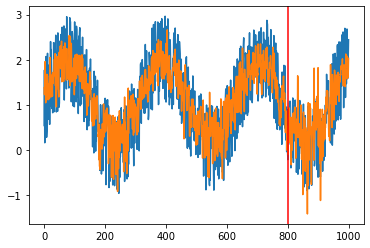

In [95]:
index = df.index.values
plt.plot(df)
plt.plot(predicted)
plt.axvline(df.index[Tp], c="r")
plt.show() 